In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns      
sns.set(style="darkgrid")
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, RandomizedSearchCV, \
                                    cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, \
                            plot_confusion_matrix , ConfusionMatrixDisplay
import imblearn
from imblearn.under_sampling import TomekLinks

import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adam
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Read Data

In [2]:
# train_df = pd.read_csv("/kaggle/input/health-insurance-cross-sell-prediction/train.csv")
# test_df = pd.read_csv("/kaggle/input/health-insurance-cross-sell-prediction/test.csv")
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.drop("id", axis=1, inplace=True)
test_df.drop("id", axis=1, inplace=True)

In [3]:
train_df.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [4]:
# Checking for missing values and remove rows
print(train_df.isnull().sum(), "\n\n")

train_df.info()

Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  object 
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  float64
 4   Previously_Insured    381109 non-null  int64  
 5   Vehicle_Age           381109 non-null  object 
 6   Vehicle_Damage        381109 non-null  object 
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  float64
 9   Vintage   

# Exploratory Data Analysis

## Demographics

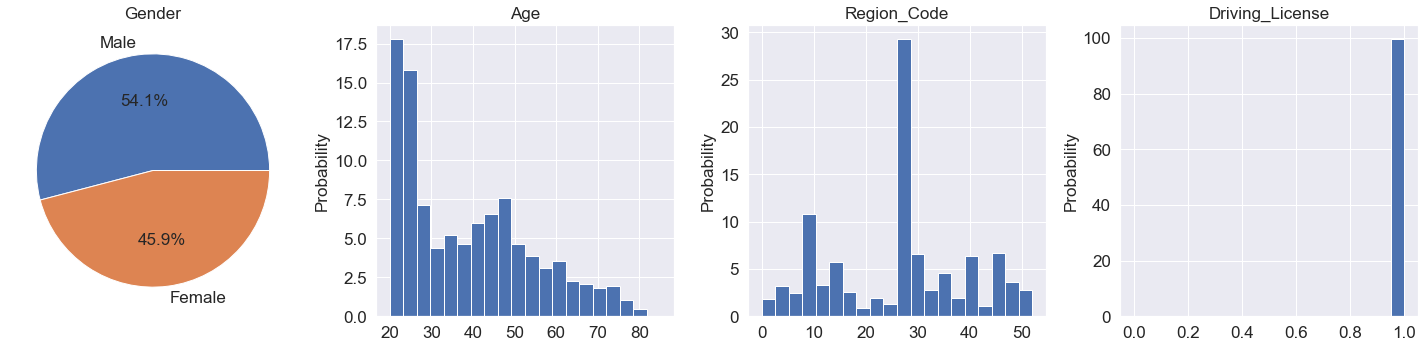

In [5]:
dummy = train_df[["Gender", "Age", "Region_Code", "Driving_License"]]
fig, ax = plt.subplots(1,4, figsize=(20,5))
dummy["Gender"].value_counts().plot.pie(autopct="%1.1f%%", ax=ax[0], fontsize=17)
ax[0].set_title("Gender", fontsize=17)
ax[0].set_ylabel("")
for i, column in enumerate(dummy.columns[1:]):    
    dummy[column].plot(kind="hist", ax=ax[i+1], fontsize=17, title=column, weights=np.ones_like(dummy[dummy.columns[0]]) * 100. / len(dummy), bins=20)
    ax[i+1].set_ylabel("Probability", fontsize=17)
    ax[i+1].title.set_size(17)
fig.tight_layout()

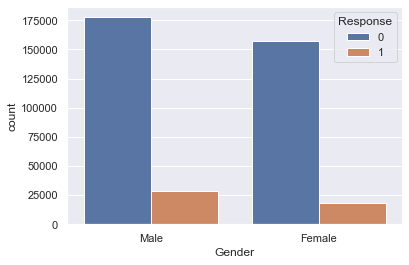

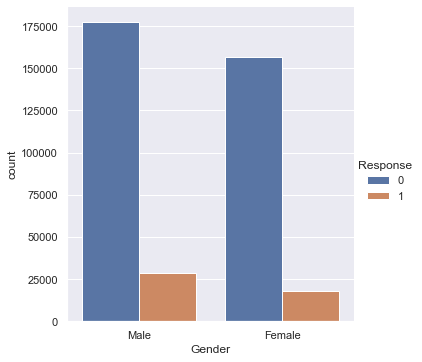

In [6]:
sns.countplot(data=train_df, x="Gender", hue="Response")
sns.catplot(kind="count", data=train_df, x="Gender", hue="Response")

## Vechicle Data

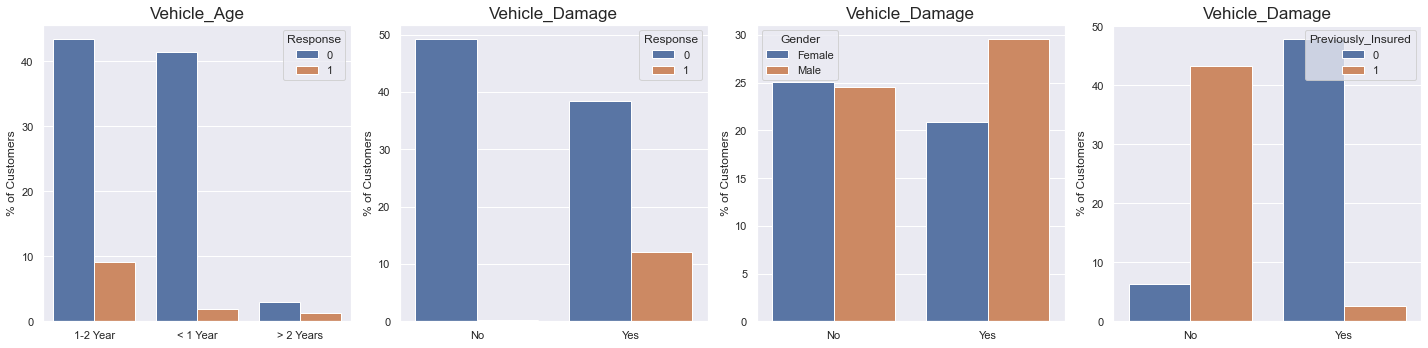

In [7]:
fig, axlist = plt.subplots(1,4, figsize=(20,5))
axis_name = "% of Customers"

for i, column in enumerate(["Vehicle_Age", "Vehicle_Damage"]):
  df2= train_df.groupby([column, "Response"])["Age"].count().to_frame()
  df2 = df2.rename({"Age": axis_name}, axis=1).reset_index()
  df2[axis_name] = df2[axis_name]/len(train_df) * 100
  ax = sns.barplot(x=column, y=axis_name, hue='Response', data=df2, 
                   ax=axlist[i])
  ax.set_title(ax.xaxis.get_label_text(), fontsize=17)
  ax.set_xlabel("")

for i, column in enumerate(["Gender", "Previously_Insured"]):
  i = i+2
  df2= train_df.groupby(["Vehicle_Damage", column])["Age"].count().to_frame()
  df2 = df2.rename({"Age": axis_name}, axis=1).reset_index()
  df2[axis_name] = df2[axis_name]/len(train_df) * 100
  ax = sns.barplot(x="Vehicle_Damage", y=axis_name, hue=column, data=df2, 
                   ax=axlist[i])
  ax.set_title(ax.xaxis.get_label_text(), fontsize=17)
  ax.set_xlabel("")
fig.tight_layout()

## Policy 

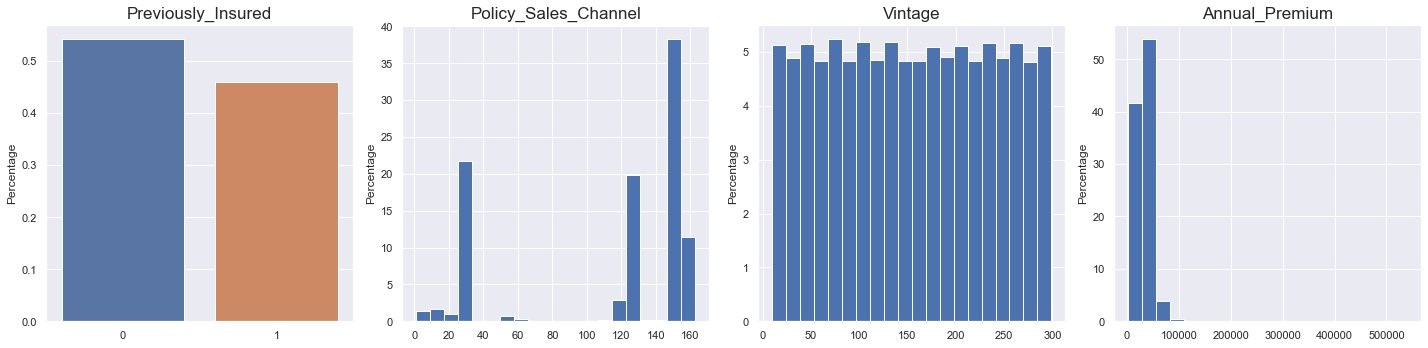

In [8]:
fig, axlist = plt.subplots(1,4, figsize=(20,5))

dummy = train_df["Previously_Insured"].value_counts(normalize="True").reset_index().rename({"Previously_Insured":"Percentage"}, axis=1)
ax = sns.barplot(data=dummy, x="index", y="Percentage", ax=axlist[0])
ax.set_xlabel("")
ax.set_title("Previously_Insured", fontsize=17)

for i, col in enumerate(["Policy_Sales_Channel", "Vintage", "Annual_Premium"]):
    ax = train_df[col].plot.hist(ax=axlist[i+1], weights=np.ones_like(train_df["Age"])*100./len(train_df), bins=20)
    ax.set_ylabel("Percentage")
    ax.set_title(col, fontsize=17)
fig.tight_layout()

### Anual Premium vs Age by Response and Gender

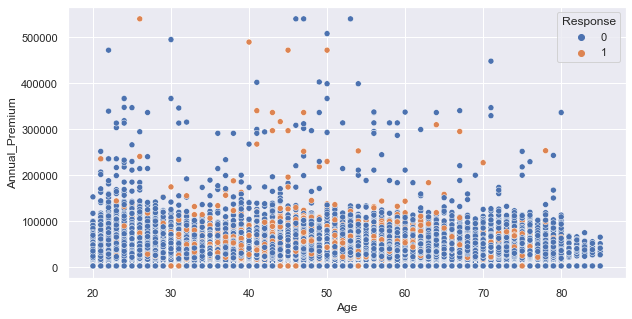

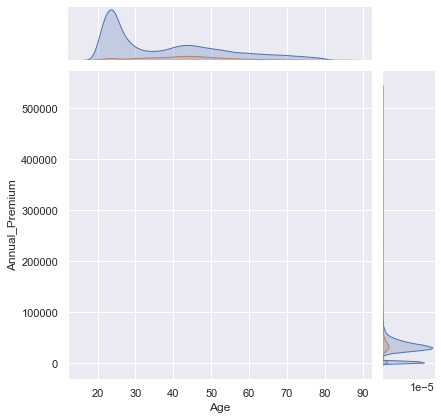

In [9]:
fig, axlist = plt.subplots(1,1, figsize=(10,5))
sns.jointplot(data=train_df, x="Age", y="Annual_Premium", hue="Response", ax=axlist)

### Vintage vs Age

<AxesSubplot:xlabel='Age', ylabel='Vintage'>

c:\users\andrei\.virtualenvs\insurance-rhn49oqo\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


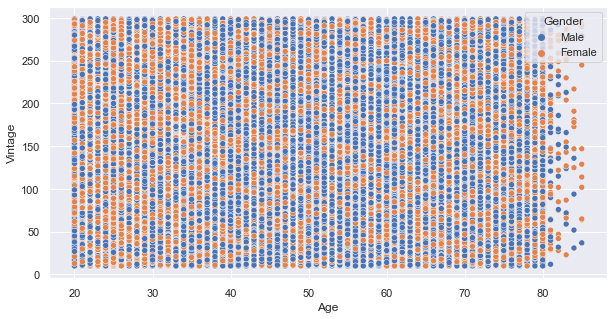

In [10]:
fig, axlist = plt.subplots(1,1, figsize=(10,5))
sns.scatterplot(data=train_df, x="Age", y="Vintage", hue="Gender", ax=axlist)

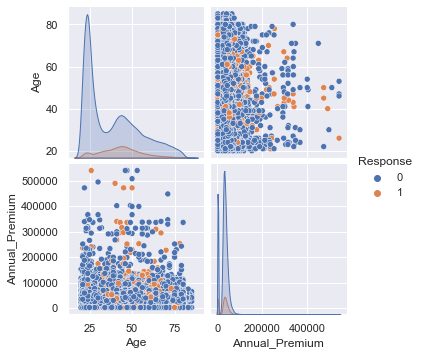

In [11]:
dummy = train_df[["Age", "Annual_Premium", "Response"]]
sns.pairplot(dummy, hue="Response")

# Data Preprocessing and Cleaning

## Pandas Version

In [12]:
# Convert all the non-numeric columns to numerical data types
cleaned_df = pd.get_dummies(train_df)
cleaned_df.head()

,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Gender_Female,Gender_Male,Vehicle_Age_1-2 Year,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,Vehicle_Damage_No,Vehicle_Damage_Yes
0,44,1,28.0,0,40454.0,26.0,217,1,0,1,0,0,1,0,1
1,76,1,3.0,0,33536.0,26.0,183,0,0,1,1,0,0,1,0
2,47,1,28.0,0,38294.0,26.0,27,1,0,1,0,0,1,0,1
3,21,1,11.0,1,28619.0,152.0,203,0,0,1,0,1,0,1,0
4,29,1,41.0,1,27496.0,152.0,39,0,1,0,0,1,0,1,0


## One Hot Encoded Version

In [13]:
# get categorical and numerical column indexes
catColNames =list(train_df.select_dtypes(include="object").columns)
numColNames =list(train_df.select_dtypes(exclude="object").columns)
catColIdx = [train_df.columns.get_loc(col) for col in catColNames]
numColIdx = [train_df.columns.get_loc(col) for col in numColNames]

# create column name list for cleaned dataset
colNames = OneHotEncoder().fit(train_df.select_dtypes(include="object"))
colNames = colNames.get_feature_names(catColNames)
colNames = list(colNames) + numColNames

# Apply OHE and Scale numerical Columns
ct = ColumnTransformer(transformers=
                      [("ohe", OneHotEncoder(),catColIdx),
                       ("std", MinMaxScaler(), numColIdx)])
cleaned_df = ct.fit_transform(train_df)
cleaned_df = pd.DataFrame(cleaned_df, columns=colNames)
cleaned_df.head()

,Gender_Female,Gender_Male,Vehicle_Age_1-2 Year,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,Vehicle_Damage_No,Vehicle_Damage_Yes,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.369231,1.0,0.538462,0.0,0.070366,0.154321,0.716263,1.0
1,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.861538,1.0,0.057692,0.0,0.057496,0.154321,0.598616,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.415385,1.0,0.538462,0.0,0.066347,0.154321,0.058824,1.0
3,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.015385,1.0,0.211538,1.0,0.048348,0.932099,0.667820,0.0
4,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.138462,1.0,0.788462,1.0,0.046259,0.932099,0.100346,0.0


## Split Dataset

In [14]:
# Split Data
X = cleaned_df.drop("Response", axis=1)
y = cleaned_df["Response"]

# Split the data into 70% training and 30% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=101) 
X_train.head()

,Gender_Female,Gender_Male,Vehicle_Age_1-2 Year,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,Vehicle_Damage_No,Vehicle_Damage_Yes,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage
314458,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.030769,1.0,0.500000,1.0,0.056551,0.932099,0.820069
67082,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.030769,1.0,0.903846,1.0,0.057624,0.932099,0.377163
338484,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.184615,1.0,0.538462,1.0,0.076624,0.932099,0.432526
332236,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.215385,1.0,0.576923,0.0,0.044795,0.981481,0.380623
61324,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.907692,1.0,0.538462,0.0,0.085061,0.746914,0.477509


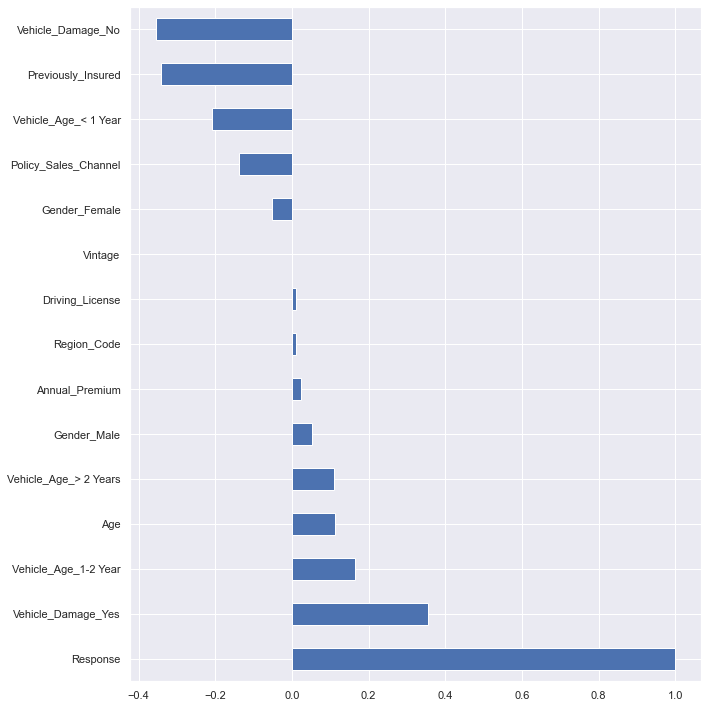

In [15]:
#Get Correlation of "Churn" with other variables:
fig = plt.figure(figsize=(10,10))
cleaned_df.corr()['Response'].sort_values(ascending = False).plot(kind='barh')
fig.tight_layout()

# Build ML Models

In [16]:
def ScoreClassifier(y_true, y_predScore, labels):
    # Get prediction label
    y_pred = list(map(np.argmax,y_predScore))
    # Tkae prediction score of only one variable --> needed by roc_curve
    y_predScore = y_predScore[:,1]
    fig, ax = plt.subplots(1,2, figsize=(10,5))

    # Plot Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", ax=ax[0], values_format="d")
    # optional parameter: xticks_rotation : {'vertical', 'horizontal'} or float

    # Plot ROC AUC
    fpr, tpr, _ = roc_curve(y_test, y_predScore)
    ax[1].plot(fpr,tpr)
    ax[1].plot((0,1), ls='dashed',color='red')
    ax[1].set_title("Recieiver operating characteristic")
    ax[1].set_xlabel("False Positive Rate")
    ax[1].set_ylabel("True Positive Rate")
    fig.tight_layout()
    plt.show()

    ## Compute ROCAUC
    roc_score = roc_auc_score(y_test, y_predScore)
    print(f"\n\nROCAUC: {roc_score}")

    # Compute Precision, Recall, Accuracy, F1-Score
    repo = classification_report(y_test, y_pred, target_names = labels)
    print(f"\n\n{repo}")
    # convert repo to pandas Dataframe
    repo = classification_report(y_test, y_pred, target_names = labels, output_dict=True)
    repo = pd.DataFrame(repo).transpose()
    
    return fig, roc_score, repo, fpr, tpr

class Classifier:
    def __init__(self, roc_score, repo, fpr, tpr):
        self.roc_score = roc_score
        self.repo = repo
        self.fpr = fpr
        self.tpr = tpr
        
class Results:
    pass   

results = Results()

## Rebalancing Dataset

### Method 1: SMOTE: Synthetic Minoerity Oversampling Technique

In [17]:
smote = imblearn.over_sampling.SMOTE(random_state=42)
X_SMOTE, y_SMOTE = smote.fit_resample(X_train, y_train)

### Method 2: TomekLinks
With this method we look for "tomek links" which are essentially support vectors and remove the datapoint from the oversampled distribution

In [18]:
tl = TomekLinks()
X_TL, y_TL = tl.fit_sample(X_train, y_train)

### Method 3: Near Miss 
This undersampling Method selectes samples based on the distance of the majority class samples to the minority class samples

In [19]:
from imblearn.under_sampling import NearMiss 
nm = NearMiss(version=3, n_neighbors_ver3=3)
X_NM, y_NM = nm.fit_resample(X_train, y_train)

## Logistic Regression using Smote

In [20]:
# Grid Search Parameters
params = {'solver': ['newton-cg', 'lbfgs', 'liblinear'],
          'C': np.logspace(-4, 4,50),  
          'penalty': ['none', 'l1', 'l2', 'elasticnet']}

# Train Random Forest Classifier using Randomized Grid Search
model_lr= LogisticRegression(max_iter=500) 
random_cv = RandomizedSearchCV(model_lr, param_distributions=params,n_iter=20, 
                               scoring="roc_auc", cv=5, n_jobs=-1, verbose=2)
random_cv.fit(X_SMOTE, y_SMOTE)
print(f"Best Score:{random_cv.best_score_} \n {random_cv.best_params_}")
model_lr = random_cv.best_estimator_.fit(X_SMOTE, y_SMOTE)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.8min finished
c:\users\andrei\.virtualenvs\insurance-rhn49oqo\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


Best Score:0.8378465223151255 
 {'solver': 'lbfgs', 'penalty': 'none', 'C': 0.5689866029018293}


c:\users\andrei\.virtualenvs\insurance-rhn49oqo\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


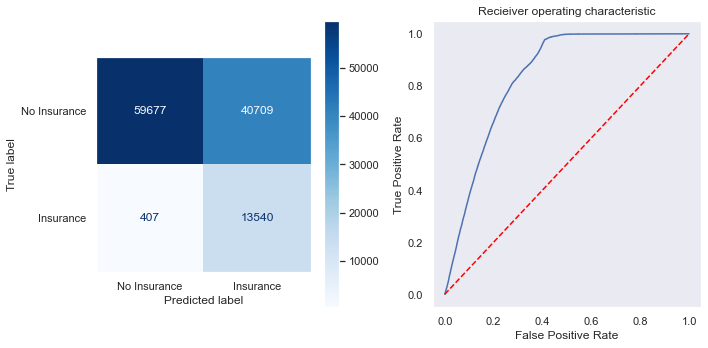



ROCAUC: 0.8357071031122799


              precision    recall  f1-score   support

No Insurance       0.99      0.59      0.74    100386
   Insurance       0.25      0.97      0.40     13947

    accuracy                           0.64    114333
   macro avg       0.62      0.78      0.57    114333
weighted avg       0.90      0.64      0.70    114333



In [21]:
labels = ["No Insurance", "Insurance"]
sns.set(style="dark")

y_predScore = model_lr.predict_proba(X_test)
fig, roc_score, repo, fpr, tpr = ScoreClassifier(y_test, y_predScore, labels)
results.logreg_smote = Classifier(roc_score, repo, fpr, tpr)

# Random Forest

In [22]:
# Grid Search Parameters
params = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, 
                                                       num = 10)],
          'max_features': ['auto', 'sqrt'],
          'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)] +[None],
          'min_samples_split': [2, 5, 10],
          'min_samples_leaf': [1, 2, 4],
          'bootstrap': [True, False]}

# Train Random Forest Classifier using Randomized Grid Search
model_rf= RandomForestClassifier(n_jobs=-1, class_weight='balanced') 
random_cv = RandomizedSearchCV(model_rf, param_distributions=params,n_iter=15, 
                               scoring="roc_auc", cv=2, verbose=2, n_jobs=-1)
random_cv.fit(X_train, y_train)
print(f"Best Score:{random_cv.best_score_} \n {random_cv.best_params_}")
model_rf = random_cv.best_estimator_.fit(X_train, y_train)

Fitting 2 folds for each of 15 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed: 20.6min remaining:  6.3min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 21.6min finished


Best Score:0.853708913191379 
 {'n_estimators': 1000, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': False}


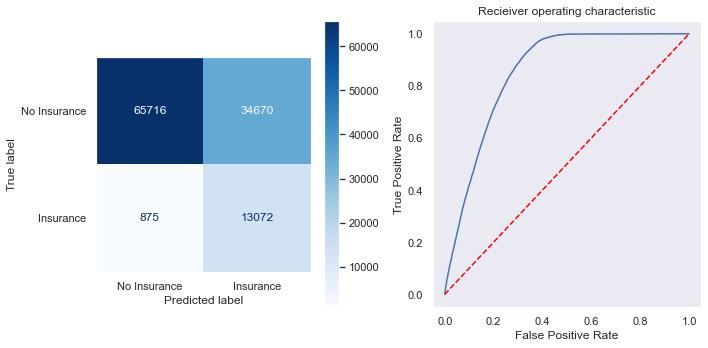



ROCAUC: 0.8535220625427508


              precision    recall  f1-score   support

No Insurance       0.99      0.65      0.79    100386
   Insurance       0.27      0.94      0.42     13947

    accuracy                           0.69    114333
   macro avg       0.63      0.80      0.61    114333
weighted avg       0.90      0.69      0.74    114333



In [23]:
labels = ["No Insurance", "Insurance"]
sns.set(style="dark")

y_predScore = model_rf.predict_proba(X_test)
fig, roc_score, repo, fpr, tpr = ScoreClassifier(y_test, y_predScore, labels)
results.randfst_smote = Classifier(roc_score, repo, fpr, tpr)

## XGBoost

In [24]:
import xgboost
# Rename Columns for XGB to work
X_dummy = X_SMOTE.rename(columns={"Vehicle_Age_< 1 Year": "Vehicle_Age_Under 1 Year", "Vehicle_Age_> 2 Years":"Vehicle_Age_More Then 2 Years"}) 
# Grid Search Parameters
params = {
    "max_depth": [3, 4, 5, 6, 8, 10, 12, 15],
    "learning_rate": [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.4, 0.45, 0.5],
    "min_child_weight": [1, 3, 5, 7],
    "gamma": [0.0, 0.1, 0.2, 0.3, 0.4],
    "colsample_bytree": [0.3, 0.4, 0.5, 0.7]
}

# Train XGBoost using Randomized Grid Search
model_xg= xgboost.XGBClassifier()
random_cv = RandomizedSearchCV(model_xg, param_distributions=params,n_iter=50, 
                               scoring="roc_auc", cv=5, n_jobs=-1, verbose=1)
random_cv.fit(X_dummy, y_SMOTE)
print(f"Best Score:{random_cv.best_score_} \n {random_cv.best_params_}")
model_xg = random_cv.best_estimator_.fit(X_dummy, y_SMOTE)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 17.0min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 23.2min finished


Best Score:0.9760432018021026 
 {'min_child_weight': 1, 'max_depth': 15, 'learning_rate': 0.3, 'gamma': 0.3, 'colsample_bytree': 0.7}


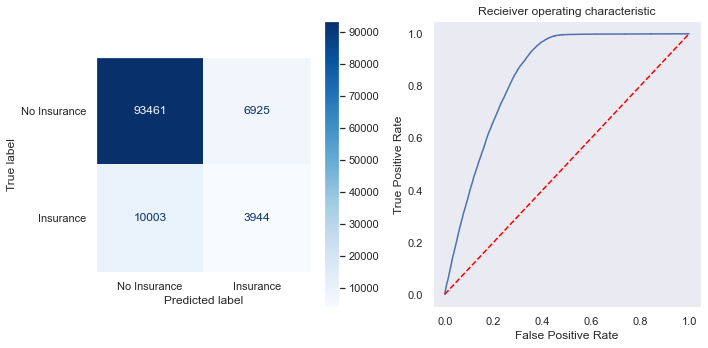



ROCAUC: 0.8418531160049877


              precision    recall  f1-score   support

No Insurance       0.90      0.93      0.92    100386
   Insurance       0.36      0.28      0.32     13947

    accuracy                           0.85    114333
   macro avg       0.63      0.61      0.62    114333
weighted avg       0.84      0.85      0.84    114333



In [25]:
labels = ["No Insurance", "Insurance"]
sns.set(style="dark")

X_dummy = X_test.rename(columns={"Vehicle_Age_< 1 Year": "Vehicle_Age_Under 1 Year", "Vehicle_Age_> 2 Years":"Vehicle_Age_More Then 2 Years"}) 
y_predScore = model_xg.predict_proba(X_dummy)
fig, roc_score, repo, fpr, tpr = ScoreClassifier(y_test, y_predScore, labels)
results.xgboost_smote = Classifier(roc_score, repo, fpr, tpr)

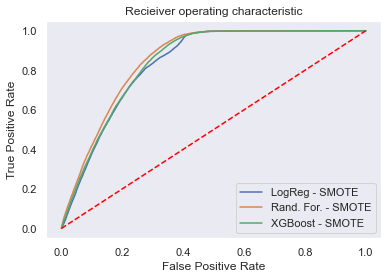

In [26]:

    plt.plot(results.logreg_smote.fpr,results.logreg_smote.tpr, label="LogReg - SMOTE")
    plt.plot(results.randfst_smote.fpr,results.randfst_smote.tpr, label="Rand. For. - SMOTE")
    plt.plot(results.xgboost_smote.fpr,results.xgboost_smote.tpr, label="XGBoost - SMOTE")
    plt.plot((0,1), ls='dashed',color='red')
    plt.title("Recieiver operating characteristic")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

## Deep Learning Approach

In [31]:
# Define Estimator Model for Randomized/GridSearchCV
def create_model(layers, dropout_rate):
  classifier = Sequential()
  
  # Add Hidden layers
  for i, nodes in enumerate(layers):
    if i == 0:
      classifier.add(Dense(nodes, activation='relu', input_dim=X_train.shape[1]))
      classifier.add(Dropout(dropout_rate))
    else: 
      classifier.add(Dense(nodes, activation='relu'))
      classifier.add(Dropout(dropout_rate))

  # Add Output Layers:
  classifier.add(Dense(1, activation = 'sigmoid'))

  # Optimizer
  # optimizer = Adam(learning_rate=learning_rate)

  # Compiling the ANN
  classifier.compile(optimizer="Adam", loss='binary_crossentropy', metrics=['accuracy'])
  return classifier

In [37]:
# Grid Parameters
model = KerasClassifier(build_fn=create_model, verbose=0)
layers = [(20, 15, 7), (40, 20), (45, 30, 15), (30, 20, 10, 5), (15,15,10,5)]
epochs = [10]
dropout_rate = [0.1]
param_grid = dict(layers=layers, epochs=epochs, dropout_rate=dropout_rate)

# Run Grid Search with DNN Regressor Architecture
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3,
                          return_train_score=True, verbose=2, n_jobs=-1)
grid_result = grid.fit(X_SMOTE, y_SMOTE, validation_split=0.3)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:  4.8min remaining:  4.2min
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  6.3min finished


Epoch 1/10
10239/10239 [==============================] - 10s 953us/step - loss: 0.4068 - accuracy: 0.7616 - val_loss: 0.7113 - val_accuracy: 0.7121
Epoch 2/10
10239/10239 [==============================] - 10s 941us/step - loss: 0.3993 - accuracy: 0.7691 - val_loss: 0.7011 - val_accuracy: 0.7031
Epoch 3/10
10239/10239 [==============================] - 10s 948us/step - loss: 0.3981 - accuracy: 0.7707 - val_loss: 0.6972 - val_accuracy: 0.6885
Epoch 4/10
10239/10239 [==============================] - 10s 946us/step - loss: 0.3978 - accuracy: 0.7710 - val_loss: 0.6882 - val_accuracy: 0.7108
Epoch 5/10
10239/10239 [==============================] - 10s 936us/step - loss: 0.3975 - accuracy: 0.7714 - val_loss: 0.7061 - val_accuracy: 0.7049
Epoch 6/10
10239/10239 [==============================] - 10s 951us/step - loss: 0.3971 - accuracy: 0.7715 - val_loss: 0.7087 - val_accuracy: 0.6712
Epoch 7/10
10239/10239 [==============================] - 10s 935us/step - loss: 0.3970 - accuracy: 0.7718

In [39]:
# Analyze Parameter Grid Result:
params_df = pd.DataFrame(grid.cv_results_,
                       columns=['params','mean_train_score',
                                'mean_test_score'])
params_df.set_index('params', inplace=True)
display(params_df.sort_values(by=["mean_test_score"], ascending=False))

print("Best Estimator:", grid.best_estimator_,
     "Best Score:",     grid.best_score_,
     "Best Params:",    grid.best_params_, sep="\n")

,mean_train_score,mean_test_score
params,,
"{'dropout_rate': 0.1, 'epochs': 10, 'layers': (40, 20)}",0.797174,0.481955
"{'dropout_rate': 0.1, 'epochs': 10, 'layers': (20, 15, 7)}",0.804137,0.478079
"{'dropout_rate': 0.1, 'epochs': 10, 'layers': (45, 30, 15)}",0.801108,0.477819
"{'dropout_rate': 0.1, 'epochs': 10, 'layers': (30, 20, 10, 5)}",0.799329,0.473481
"{'dropout_rate': 0.1, 'epochs': 10, 'layers': (15, 15, 10, 5)}",0.803902,0.471238


Best Estimator:
Best Score:
0.4819550957181491
Best Params:
{'dropout_rate': 0.1, 'epochs': 10, 'layers': (40, 20)}
